# Building Neural Net lib (multilayer preception) in micrograd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        name = getattr(n, 'label', '')
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # for any value in the graph, create a rectangular('record') op node for it
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to n1._op to n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [3]:
class Value:
    def __init__(self, data , _children=() , _op = ''  ,label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None 

    def __repr__(self):
        return "Value(data = %.4f, op = %s)" % (self.data, self._op)
    
    def __add__(self , other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data , (self , other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self , other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):   
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t,(self , ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward() 

In [4]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
    



In [5]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data = 0.1940, op = tanh)

In [6]:
n.parameters()

[Value(data = -0.7505, op = ),
 Value(data = 0.1419, op = ),
 Value(data = 0.5661, op = ),
 Value(data = -0.6453, op = ),
 Value(data = 0.2466, op = ),
 Value(data = -0.0826, op = ),
 Value(data = -0.7778, op = ),
 Value(data = -0.9284, op = ),
 Value(data = -0.2017, op = ),
 Value(data = 0.7427, op = ),
 Value(data = -0.7942, op = ),
 Value(data = -0.6223, op = ),
 Value(data = 0.0810, op = ),
 Value(data = 0.5636, op = ),
 Value(data = -0.7344, op = ),
 Value(data = 0.7331, op = ),
 Value(data = -0.5238, op = ),
 Value(data = 0.5037, op = ),
 Value(data = -0.5978, op = ),
 Value(data = 0.3222, op = ),
 Value(data = 0.9733, op = ),
 Value(data = 0.2050, op = ),
 Value(data = -0.8492, op = ),
 Value(data = 0.9661, op = ),
 Value(data = -0.7876, op = ),
 Value(data = -0.3157, op = ),
 Value(data = -0.3600, op = ),
 Value(data = 0.8599, op = ),
 Value(data = -0.7760, op = ),
 Value(data = 0.2048, op = ),
 Value(data = 0.9838, op = ),
 Value(data = -0.1073, op = ),
 Value(data = 0.0840, o

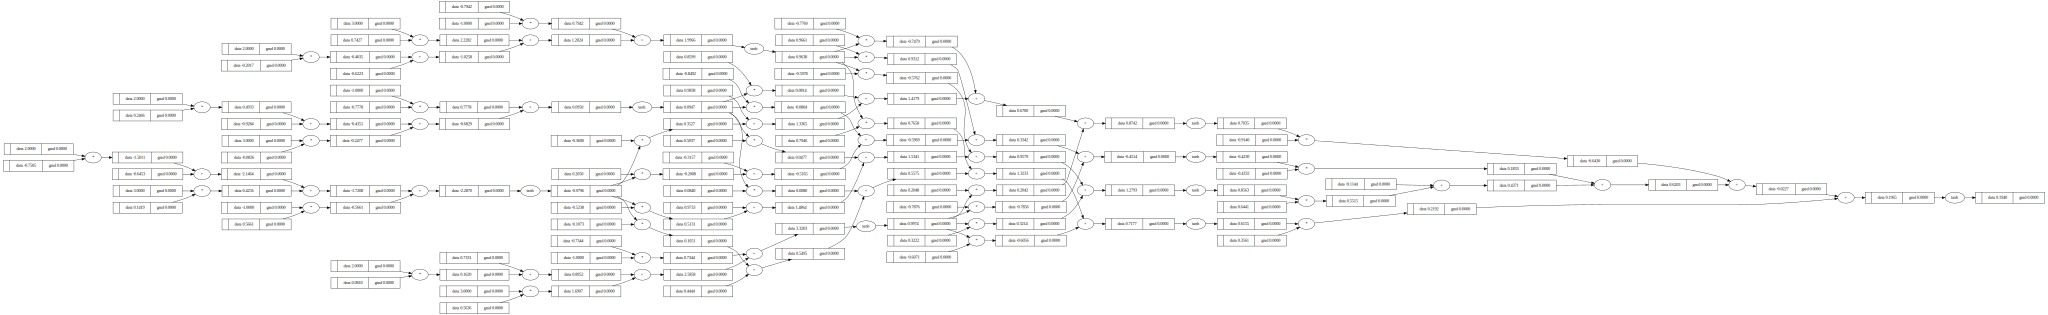

In [7]:

draw_dot(n(x))

In [8]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 2.0, -1.0]
]

ys = [1.0, -1.0, -1.0, -1.0] # desired targets

In [9]:
for k in range(5000):
# forward pass
    ypreds = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
# backward pass
    for p in n.parameters():
        p.grad = 0.0 
    
    loss.backward()

# update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 3.59874193072041
1 2.5115863987417204
2 2.307307278770047
3 2.2075321478465706
4 2.1335800933869624
5 2.0698426144406037
6 2.0076126504198286
7 1.9394772968886285
8 1.862060115809605
9 1.777875865609904
10 1.6911738307387219
11 1.6033658315623778
12 1.513319986115238
13 1.4187538080321798
14 1.3176321383929863
15 1.2096275195179191
16 1.1370074649207704
17 2.0162989414842065
18 3.5916610815884984
19 2.271601018817038
20 3.036211378574647
21 1.6313202146390418
22 1.8407603657347915
23 2.0213746054506845
24 2.1372074242058496
25 2.1858463353890327
26 1.7552540214738086
27 2.1255453014904155
28 1.8611459152116703
29 2.384780282420099
30 1.2723627901229737
31 1.594470621163909
32 2.739270820728444
33 1.8039792168588638
34 1.6973228775222213
35 1.6735720673534813
36 2.0569674358363206
37 2.2097206468333015
38 1.1946174363381294
39 1.237614706757908
40 2.3551918565585335
41 2.3528540009231866
42 1.0630080888822653
43 0.9044814575874082
44 1.296135707842418
45 2.415740278360918
46 0.7398448

In [10]:
ypreds

[Value(data = 0.9921, op = tanh),
 Value(data = -0.9967, op = tanh),
 Value(data = -0.9962, op = tanh),
 Value(data = -0.9939, op = tanh)]